In [1]:
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

from queries import *
from reconstruct import *
from plotting import *

In [2]:
df = pd.read_csv("./dp-query-release/datasets/ppmf/ppmf_01097007000.csv")
# df = pd.read_csv("./dp-query-release/datasets/ppmf/ppmf_01.csv")
df = df[['TABBLK', 'CENRACE', 'CENHISP', 'QAGE', 'QSEX']]
df["QAGE"] = df["QAGE"].apply(age_buckets)

In [ ]:
# block level reconstruction of a tract
block_queries = get_block_queries(df)
recon = reconstruct_at_block_level(block_queries)
tests_passed(block_queries, recon)
get_num_reconstructed(recon, df)

num_runs = 10
all_recons = get_n_reconstructions(block_queries, num_runs, df.columns)
all_recons_unique = all_recons.groupby(["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX"], as_index=False).size()
all_recons_unique = all_recons_unique.sort_values(by=['size'], ascending=False)

title = f'Census Tract: 01097007000, Block-Level, '
sr = plot_match_rate(all_recons_unique, df, title, num_runs, save=True)

Reconstructing dataset 1/100
Reconstructing dataset 2/100
Reconstructing dataset 3/100
Reconstructing dataset 4/100
Reconstructing dataset 5/100
Reconstructing dataset 6/100
Reconstructing dataset 7/100
Reconstructing dataset 8/100
Reconstructing dataset 9/100
Reconstructing dataset 10/100
Reconstructing dataset 11/100
Reconstructing dataset 12/100
Reconstructing dataset 13/100
Reconstructing dataset 14/100
Reconstructing dataset 15/100
Reconstructing dataset 16/100
Reconstructing dataset 17/100
Reconstructing dataset 18/100
Reconstructing dataset 19/100
Reconstructing dataset 20/100
Reconstructing dataset 21/100
Reconstructing dataset 22/100
Reconstructing dataset 23/100
Reconstructing dataset 24/100
Reconstructing dataset 25/100
Reconstructing dataset 26/100
Reconstructing dataset 27/100
Reconstructing dataset 28/100
Reconstructing dataset 29/100
Reconstructing dataset 30/100
Reconstructing dataset 31/100
Reconstructing dataset 32/100
Reconstructing dataset 33/100
Reconstructing data

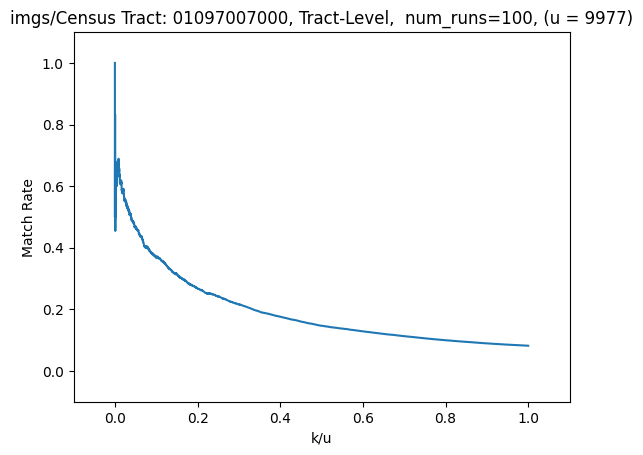

In [4]:
# tract level reconstruction that has to reconstruct block id
tract = df.copy()
tract["TABBLK"] = 0

blk_ids, blk_counts = get_blk_ids_and_counts(df)

tract_queries = get_block_queries(tract)
# runs_arr = [1, 2, 5, 10, 100]
runs_arr = [100]

for num_runs in runs_arr:
    all_recons = get_n_reconstructions(tract_queries, num_runs, df.columns, 
                                       block_level=False, blk_ids=blk_ids, blk_counts=blk_counts)
    all_recons_unique = all_recons.groupby(["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX"], as_index=False).size()
    all_recons_unique = all_recons_unique.sort_values(by=['size'], ascending=False)

    title = f'Census Tract: 01097007000, Tract-Level, '
    plot_match_rate(all_recons_unique, df, title, num_runs, save=True)

In [ ]:
# tract level reconstruction that DOES NOT have to reconstruct block id
tract = df.copy()
tract["TABBLK"] = 0

blk_ids, blk_counts = get_blk_ids_and_counts(df)

tract_queries = get_block_queries(tract)
runs_arr = [5]

for num_runs in runs_arr:
    all_recons = get_n_reconstructions(tract_queries, num_runs, df.columns, 
                                       block_level=False, blk_ids=blk_ids, blk_counts=blk_counts)
    all_recons_unique = all_recons.groupby(["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX"], as_index=False).size()
    all_recons_unique = all_recons_unique.sort_values(by=['size'], ascending=False)

    title = f'Census Tract: 01097007000, Tract-Level, Without Block '
    plot_match_rate(all_recons_unique, df, title, num_runs, save=True)

In [ ]:
# tests_passed(tract_queries, recon)
# get_num_reconstructed(recon, df)

In [ ]:
tract = df.copy()
tract["TABBLK"] = 0

blk_ids, blk_counts = get_blk_ids_and_counts(df)
tract_queries = get_block_queries(tract)

num_runs = 10
all_recons = get_n_reconstructions(tract_queries, num_runs, df.columns, 
                                   block_level=False, blk_ids=blk_ids, blk_counts=blk_counts)


new_recons = pd.DataFrame(columns=["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX", "Confidence"])

# get unique (blk, race, hisp, age, sex) but disregarding the "run" columns. This is to just get an iterator.
all_recons_unique = all_recons.groupby(["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX"], 
                                       as_index=False).size().drop(columns="size")

counter = 0
for idx, row in all_recons_unique.iterrows():
    if counter % 100 == 0:
        print(counter)
    counter += 1
    (blk_id, race, hisp, age, sex) = row
    
    # here I want the grouping by run too, so I know how many runs a row appeared in. 
    q = all_recons.query(f'TABBLK == {blk_id} and ' +
                          f'CENRACE == {race} and ' +
                          f'CENHISP == {hisp} and ' +
                          f'QAGE == {age} and ' +
                          f'QSEX == {sex}').groupby(all_recons.columns.tolist(), as_index=False).size()

    q = q.sort_values(by=['size'], ascending=False)

    while len(q) > 0:
        for i in range(min(q["size"])):
            new_recons.loc[len(new_recons)] = [blk_id, race, hisp, age, sex, len(q)]

            q["size"] -= min(q["size"])
        q.drop(q[q["size"] == 0].index, inplace = True)

In [ ]:
new_recons = new_recons.sort_values(by=['Confidence'], ascending=False)
new_recons

In [ ]:
title = f'test'
plot_match_rate(new_recons[new_recons["Confidence"] > 90], df, title, num_runs, stable=True)

In [ ]:
all_recons_unique = all_recons.groupby(["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX"], 
                                       as_index=False).size()
all_recons_unique = all_recons_unique.sort_values(by=['size'], ascending=False)
all_recons_unique

counter = 0
for idx, row in all_recons_unique.iterrows():
    if counter % 100 == 0:
        print(counter)
    counter += 1
    (blk_id, race, hisp, age, sex, size) = row
    
    var = all_recons.query(f'TABBLK == {blk_id} and ' +
                          f'CENRACE == {race} and ' +
                          f'CENHISP == {hisp} and ' +
                          f'QAGE == {age} and ' +
                          f'QSEX == {sex}').groupby(all_recons.columns.tolist(), as_index=False).size()["size"].var()
    
    all_recons_unique.loc[idx, "var"] = var

In [ ]:
all_recons_unique[(all_recons_unique["size"] > 80)]

We know there is a coorelation with total number of rows seen. That is the confidence metric of Dick et al. 

But what if we wish for confidence in multiplicities?

At first I thought - if i see the same row n times in n reconstructions, that is high confidence. 
But that is not true, an illustrating counter-example:

Say we did 4 reconstructions. 
Scenario A: We see row R (99, 99, 1, 1) times. 
Scenario B: We see row R (50, 50, 50, 50) times. 

Both are equivalent in terms of the signal we know how to interpret that is R exists in the dataset 
with maybe high confidence. 

But in Scenario B we would have erroneously claimed that row R has multiplicity 50 with high confidence. 

How could we have avoided this?

We would want:
High avg, low variance. 

Average ta high hune bhai halyo if we are going down the df by size, bc we will just be dividing the size by n. k chai 
hernu paryo bhane variance hernu paryo. 

I should document why this did not work.

In [ ]:
(blk_id, race, hisp, age, sex, size, var) = all_recons_unique.iloc[2645]
df.query(f'TABBLK == {blk_id} and ' +
         f'CENRACE == {race} and ' +
         f'CENHISP == {hisp} and ' +
         f'QAGE == {age} and ' +
         f'QSEX == {sex}')